<a href="https://colab.research.google.com/github/juliosdutra/Controle_de_Processos_UFES/blob/main/7.Controller-tuning/Sintonia_de_controladores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalar e importas as bibliotecas necessárias

In [1]:
! pip install -qq control

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.1/455.1 kB 9.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import control as ct
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Identificar o modelo do processo

Considere um problema em que a corrente de um processo deve ser aquecida usando um trocador de calor de casco e tubo. A temperatura de saída é controlada ajustando a válvula de vapor.

Durante um teste experimental em malha aberta, a pressão do vapor Ps foi alterada repentinamente de 18 a 20 psi e foram obtidos os dados de temperatura na tabela de dados experimentais.

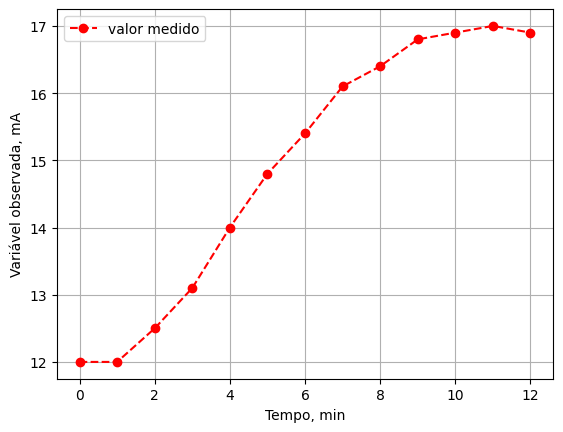

In [3]:
# Dados experimentais
t = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
T_2m = np.array([12, 12, 12.5, 13.1, 14, 14.8, 15.4, 16.1, 16.4, 16.8, 16.9, 17, 16.9])

plt.plot(t,T_2m, '--or', label = 'valor medido')
plt.xlabel('Tempo, min')
plt.ylabel('Variável observada, mA')
plt.legend()
plt.grid()

## Identificação do processo usando o método da curva de reação

Ganho estacionário do processo: Kp = 2.5000
Tempo-morto: theta = 2.00; Constante de tempo: taup = 5.00


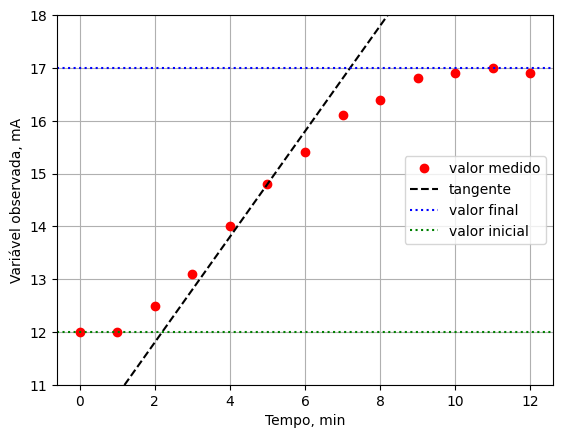

In [4]:
# Dados do teste experimental
Delta_Ps = 20-18
Delta_T2m = 17-T_2m[0]

# Ganho estacionário
Kp =  Delta_T2m/Delta_Ps
print(f'Ganho estacionário do processo: Kp = {Kp:1.4f}')

# reta tangente no ponto de inflexão
t_inf = 5.0
y_inf = 14.8
m = (17-12)/(7.0-2.0)
reta_tangente = m * (t-t_inf) + y_inf

# Tempo-morto e constante de tempo ()
theta = 2.0
taup = 7.0-theta
print(r'Tempo-morto: theta = %1.2f; Constante de tempo: taup = %1.2f' %(theta, taup))

plt.plot(t, T_2m, 'or', label = 'valor medido')
plt.plot(t, reta_tangente, '--k', label='tangente')
plt.axhline(y=17, linestyle = ':', color = 'blue', label = 'valor final')
plt.axhline(y=12, linestyle = ':', color = 'green', label = 'valor inicial')

plt.xlabel('Tempo, min')
plt.ylabel('Variável observada, mA')
plt.ylim([11, 18])
plt.legend()
plt.grid()

Analisando a figura com a reta tangente no ponto de inflexão, temos que:
* tempo-morto: $\theta = 2.0$ min;
* constante de tmepo: $\tau = 7.0-\theta = 5.0$ min

Dessa forma,
$$ G_p(s)=\frac{2.5 e^{-2s}}{5s+1}$$

## Validar o modelo da curva de reação

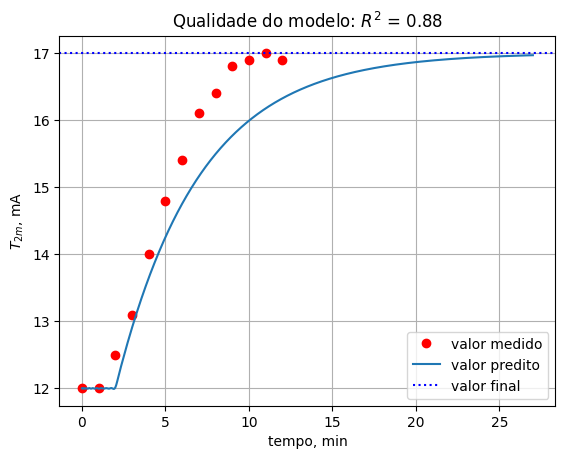

In [5]:
# Implementar o modelo
s = ct.tf('s')
Gtd = ct.tf(*ct.pade(theta,20))
Gp = Kp/(taup*s+1)*Gtd

# Testar o modelo na mesma condição dos dados
tval0, yval0 = ct.step_response(Gp,T=t)
Tval0 = Delta_Ps*yval0 + T_2m[0]

tval, yval = ct.step_response(Gp,T=5*taup+theta)

plt.plot(t, T_2m, 'or', label = 'valor medido')
plt.plot(tval, Delta_Ps*yval + T_2m[0] , label='valor predito')
plt.axhline(y=17, linestyle = ':', color = 'blue', label = 'valor final')

plt.xlabel('tempo, min')
plt.ylabel(r'$T_{2m}$, mA')
plt.title(r'Qualidade do modelo: $R^2$ = %1.2f' %r2_score(T_2m, Tval0) )
plt.legend()
plt.grid()

## Identificação do processo segundo Sundaresan e Krishnaswamy

In [7]:
t1 = 3.5 # 35.3% de Delta_T2m
t2 = 7.0 # 85.3% de Delta_T2m

theta = 1.3*t1 - 0.29*t2
taup = 0.67*(t2-t1)

print('Processo: Kp = %1.3f  tau = %1.3f  theta = %1.3f' %(Kp, taup, theta))


Processo: Kp = 2.500  tau = 2.345  theta = 2.520


## Validar o modelo identificado

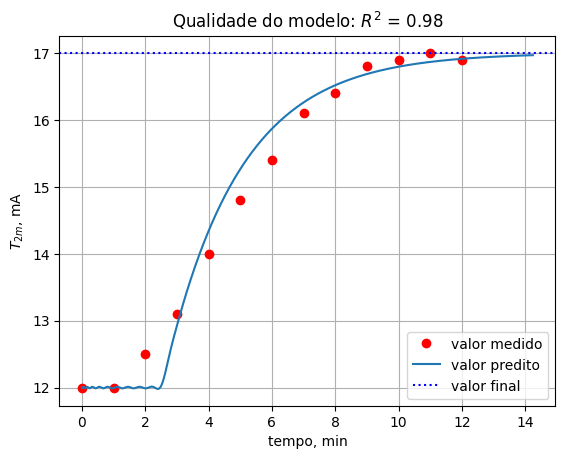

In [8]:
# Implementar o modelo
s = ct.tf('s')
Gtd = ct.tf(*ct.pade(theta,20))
Gp = Kp/(taup*s+1)*Gtd

# Testar o modelo na mesma condição dos dados
tval0, yval0 = ct.step_response(Gp,T=t)
Tval0 = Delta_Ps*yval0 + T_2m[0]

tval, yval = ct.step_response(Gp,T=5*taup+theta)

plt.plot(t, T_2m, 'or', label = 'valor medido')
plt.plot(tval, Delta_Ps*yval + T_2m[0] , label='valor predito')
plt.axhline(y=17, linestyle = ':', color = 'blue', label = 'valor final')

plt.xlabel('tempo, min')
plt.ylabel(r'$T_{2m}$, mA')
plt.title(r'Qualidade do modelo: $R^2$ = %1.2f' %r2_score(T_2m, Tval0) )
plt.legend()
plt.grid()

# Ajuste dos parâmetros do controlador


Sistema: K = 1.688  tau = 2.345  theta = 2.520
IMC: Kc = 0.28 tauI = 2.35 MG = 4.00
ITAE: Kc = 0.47 tauI = 3.65 MG = 2.84
ZN: Kc = 0.76 tauI = 4.58 MG = 1.87


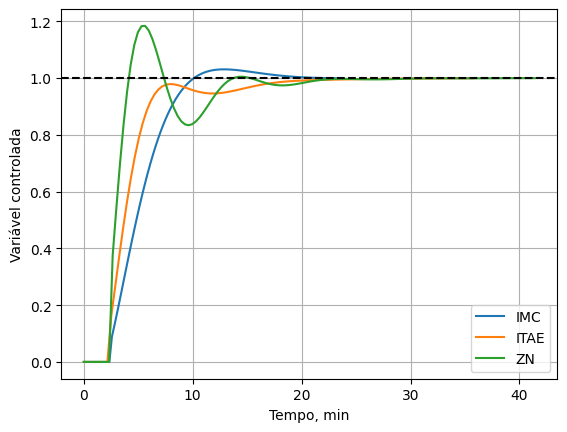

In [41]:
# Sistema a ser controlado
Kv = 0.9
Kip = 0.75

Gtd = ct.tf(*ct.pade(theta,1)) # Padé deve ser ajustado
Gp = Kp/(taup*s+1)*Gtd

G = Kv*Kip*Gp # este é o modelo do processo, sem o controlador: Gtil
K = G.dcgain()
print('\nSistema: K = %1.3f  tau = %1.3f  theta = %1.3f' %(K, taup, theta))

# sintonia IMC
tau_c = theta # Skogestad

# Sintonias dos controladores
## IMC
IMC = [taup/(K*(tau_c+theta)), taup, 'IMC']

## ITAE
A, B, C, D = 0.859, -0.977, 0.674, -0.680
r = theta/taup
ITAE = [(A/K)*(r)**B, taup/(C*(r)**D), 'ITAE']

## Ziegler-Nichols
MG, MF, wc, wg = ct.margin(G)
Ku = MG
Pu = 2*np.pi/wc
ZN = [0.45*Ku, Pu/1.2, 'ZN'] # Ajuste fino pode ser feito

# Simulação da malha fechada
sintonias = [IMC, ITAE, ZN]

for par in sintonias:

  Kc, tauI, metodo = par
  Gc = Kc*(1 + 1/(tauI*s)) # controlador PI
  MG, MF, wc, wg = ct.margin(Gc*Kv*Kip*Gp)
  print(f'{metodo}: Kc = {Kc:1.2f} tauI = {tauI:1.2f} MG = {MG:1.2f}')

  G_servo = ct.minreal( Gc*Kv*Kip*Gp/(1 + Gc*Kv*Kip*Gp), verbose=False  )
  t, y = ct.step_response(G_servo)
  y[t<=theta] = 0.0 # forçando mudança nula em y para t < tempo-morto
  plt.plot(t, y, label = metodo)

plt.axhline(y=1, linestyle='--', color = 'black')
plt.xlabel('Tempo, min')
plt.ylabel('Variável controlada')
plt.legend()
plt.grid()

# Análise dos resultados

Digite aqui sua análise.

## Teste de robustez mudando a equação da FT do processo

IMC: Kc = 0.28 tauI = 2.35 MG = 2.02
ITAE: Kc = 0.47 tauI = 3.65 MG = 1.36


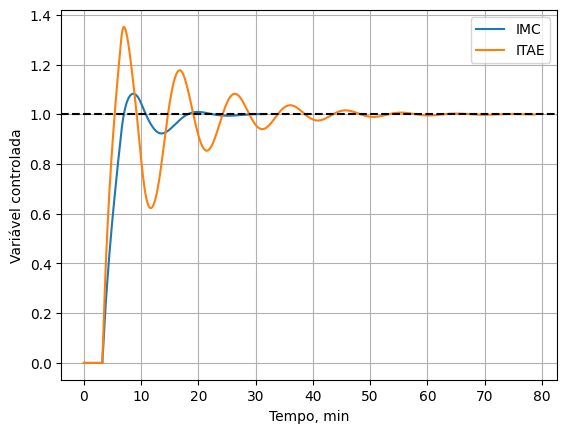

In [43]:
# Sistema a ser controlado
Kv = 0.9
Kip = 0.75

Gtd = ct.tf(*ct.pade(3.25,15)) # Padé deve ser ajustado
Gp = 2.55/(s+1)*Gtd

G = Kv*Kip*Gp # este é o modelo do processo, sem o controlador: Gtil
K = G.dcgain()


# Simulação da malha fechada

for par in sintonias:

  Kc, tauI, metodo = par
  Gc = Kc*(1 + 1/(tauI*s)) # controlador PI
  MG, MF, wc, wg = ct.margin(Gc*Kv*Kip*Gp)
  print(f'{metodo}: Kc = {Kc:1.2f} tauI = {tauI:1.2f} MG = {MG:1.2f}')

  G_servo = ct.minreal( Gc*Kv*Kip*Gp/(1 + Gc*Kv*Kip*Gp), verbose=False  )
  t, y = ct.step_response(G_servo)
  y[t<=3.25] = 0.0 # forçando mudança nula em y para t < tempo-morto
  plt.plot(t, y, label = metodo)

plt.axhline(y=1, linestyle='--', color = 'black')
plt.xlabel('Tempo, min')
plt.ylabel('Variável controlada')
plt.legend()
plt.grid()

Qual é sua análise para este caso?